In [1]:
import sys
import os
import re
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import mne
from mne_bids import write_raw_bids, BIDSPath
import re

from smooth import *


In [2]:
# set different path to load and save data
ds_root_mem='../data/preprocessData/raw/mem'
ds_root_perc='../data/preprocessData/raw/perc'
tgt_dir='..'

dir_preprocess_mem=os.path.join(tgt_dir,'data','preprocessData','CPP','mem')
if not os.path.exists(dir_preprocess_mem):
    os.makedirs(dir_preprocess_mem)

dir_preprocess_perc=os.path.join(tgt_dir,'data','preprocessData','CPP','perc')
if not os.path.exists(dir_preprocess_perc):
    os.makedirs(dir_preprocess_perc)

result_dir_joint_modeling_mem=os.path.join(tgt_dir,'results','joint-modeling_mem')
if not os.path.exists(result_dir_joint_modeling_mem):
    os.makedirs(result_dir_joint_modeling_mem)

result_dir_joint_modeling_perc=os.path.join(tgt_dir,'results','joint-modeling_perc')
if not os.path.exists(result_dir_joint_modeling_perc):
    os.makedirs(result_dir_joint_modeling_perc)


下面两个cell用于提取CPP

In [3]:
# save CPP for memory
sub_dir = [f'ACC{i:03}' for i in range(14,37) ]
for sub in sub_dir:

    data_eeg_mem = scipy.io.loadmat(os.path.join(ds_root_mem, 'responseLock_'+sub+'mem.mat' ))['data_responseLock_mem']
    row4CPP = [26,27,28]  #cp1,cpz,cp2

    data_CPP_mem = np.empty((data_eeg_mem.shape[1], 601)) #因为已经处理过了，所以最多601
    for trial in range(data_eeg_mem.shape[1]):
        data_CPP_trial = data_eeg_mem[0,trial][row4CPP, :]

        data_CPP_mean = np.mean(data_CPP_trial, axis=0)
        trial_length = data_CPP_trial.shape[1]

        if trial_length < 601:
            # 反应时不够的在前面用 0 填充，因为后面是对齐的
            padded_data = np.pad(data_CPP_mean, (601 - trial_length, 0), mode='constant', constant_values=0)
            data_CPP_mem[trial, :] = padded_data
        else:
            data_CPP_mem[trial, :] = data_CPP_mean

        # save eeg data
        data_CPP_save={
            "data_CPP_mem":data_CPP_mem
        }
        save_path=os.path.join(dir_preprocess_mem,'CPP_'+sub+'mem.mat')
        scipy.io.savemat(save_path, data_CPP_save)     

In [4]:
# save CPP for perception
sub_dir = [f'ACC{i:03}' for i in range(14,37) ]
for sub in sub_dir:

    data_eeg_perc = scipy.io.loadmat(os.path.join(ds_root_perc, 'responseLock_'+sub+'perc.mat' ))['data_responseLock_perc']
    row4CPP = [26,27,28]  #cp1,cpz,cp2

    data_CPP_perc = np.empty((data_eeg_perc.shape[1], 601)) #因为已经处理过了，所以最多601
    for trial in range(data_eeg_perc.shape[1]):
        data_CPP_trial = data_eeg_perc[0,trial][row4CPP, :]

        data_CPP_mean = np.mean(data_CPP_trial, axis=0)
        trial_length = data_CPP_trial.shape[1]

        if trial_length < 601:
            # 反应时不够的在前面用 0 填充，因为后面是对齐的
            padded_data = np.pad(data_CPP_mean, (601 - trial_length, 0), mode='constant', constant_values=0)
            data_CPP_perc[trial, :] = padded_data
        else:
            data_CPP_perc[trial, :] = data_CPP_mean

        # save eeg data
        data_CPP_save={
            "data_CPP_perc":data_CPP_perc
        }
        save_path=os.path.join(dir_preprocess_perc,'CPP_'+sub+'perc.mat')
        scipy.io.savemat(save_path, data_CPP_save)     

下面两个cell用于得到ams等值

In [ ]:
# ddm data for memory
sampleRate = 500

data_mem_whole = []
joint_result_all_mem = []

for sub in [f'ACC{i:03d}' for i in range(14,37)]:

    data_mem = scipy.io.loadmat(os.path.join(dir_preprocess_mem,'CPP_'+sub+'mem.mat'))['data_CPP_mem']

    # EEG process, prepare for whole subjucts
    data_mem_mean4trial = np.nanmean(data_mem, axis=0)

    data_mem_whole.append(data_mem_mean4trial) #for plot

    # prepare for ddm
    ## prepare empty dataset
    ams_mem = np.empty((data_mem.shape[0],1))
    pams_mem = np.empty((data_mem.shape[0],1))
    slps_mem = np.empty((data_mem.shape[0],1))

    ## set time parameters: ams and slps(-0.018, 0.08); pams(-0.05,0.05)
    t4ams_slps_first = 0.218
    t4ams_slps_last = 0.192

    t4pams_first = 0.205
    t4pams_last = 0.195

    # this for-loop is for ams and pams
    for trial in range(data_mem.shape[0]):

        data_mem_perTrial_ams = data_mem[trial,(-int(t4ams_slps_first*sampleRate)) :(-int(t4ams_slps_last*sampleRate-1))]
        ams_mean_mem = np.nanmean(data_mem_perTrial_ams)

        data_mem_perTrial_pams = data_mem[trial,(-int(t4pams_first*sampleRate)) :(-int(t4pams_last*sampleRate-1))]
        pams_mean_mem = np.nanmax(data_mem_perTrial_pams)

        ams_mem[trial,0] = ams_mean_mem
        pams_mem[trial,0] = pams_mean_mem

    # this is for slps because of 'smooth'
    data_mem = pd.DataFrame(data_mem)
    data_mem = smooth(data_mem, epoch_time=601, sample_rate=500)

    start_slps= -int(t4ams_slps_first*sampleRate)
    end_slps = -int(t4ams_slps_last*sampleRate-1)

    for trial in range(data_mem.shape[0]):
        data_mem_perTrial_slps = data_mem.iloc[trial,start_slps:end_slps]

        x = np.arange(len(data_mem_perTrial_slps)) * (1/sampleRate)  # 转换为秒
        y = data_mem_perTrial_slps
        slps_mem[trial, 0] = np.polyfit(x, y, 1)[0]  # 斜率

    joint_result_mem = np.column_stack((ams_mem, pams_mem, slps_mem))
    joint_result_withHeader_mem = pd.DataFrame(joint_result_mem, columns=['ams', 'pams', 'slps'])
    joint_result_withHeader_mem['subj_idx'] = sub
    joint_result_withHeader_mem['subj_idx'] = joint_result_withHeader_mem['subj_idx'].replace(regex=True, to_replace=r'ACC0*(\d+)', value=r'\1')

    joint_result_all_mem.append(joint_result_withHeader_mem)

#save joint-modeling
joint_modeling_final_mem = pd.concat(joint_result_all_mem, axis=0, ignore_index=True)

joint_modeling_final_mem.insert(loc=4, column='slp_quantile', value=joint_modeling_final_mem.groupby(['subj_idx']).slps.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))
joint_modeling_final_mem.insert(loc=4, column='am_quantile', value=joint_modeling_final_mem.groupby(['subj_idx']).ams.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))
joint_modeling_final_mem.insert(loc=4, column='pam_quantile', value=joint_modeling_final_mem.groupby(['subj_idx']).pams.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))

# Normalize the features by subject and coherence (subtract the mean and divide by the standard deviation within each group)
joint_modeling_final_mem['ams'] = joint_modeling_final_mem.groupby(['subj_idx']).ams.transform(lambda x: (x - x.mean()) / x.std())
joint_modeling_final_mem['slps'] = joint_modeling_final_mem.groupby(['subj_idx']).slps.transform(lambda x: (x - x.mean()) / x.std())
joint_modeling_final_mem['pams'] = joint_modeling_final_mem.groupby(['subj_idx']).pams.transform(lambda x: (x - x.mean()) / x.std())

# Bin the features based on quantiles and calculate the mean for each bin
# Bin the 'am' feature by 'am_quantile' and calculate the mean for each bin
mean_am = joint_modeling_final_mem.groupby(['subj_idx', 'am_quantile']).ams.mean().reset_index()
mean_am.rename(columns={'ams': 'am_bin'}, inplace=True)  # Rename the binned column
joint_modeling_final_mem = pd.merge(joint_modeling_final_mem, mean_am, on=['subj_idx', 'am_quantile'], how='left')

# Bin the 'slp' feature by 'slp_quantile' and calculate the mean for each bin
mean_slp = joint_modeling_final_mem.groupby(['subj_idx', 'slp_quantile']).slps.mean().reset_index()
mean_slp.rename(columns={'slps': 'slp_bin'}, inplace=True)
joint_modeling_final_mem = pd.merge(joint_modeling_final_mem, mean_slp, on=['subj_idx',  'slp_quantile'], how='left')

# Bin the 'pam' feature by 'pam_quantile' and calculate the mean for each bin
mean_pam = joint_modeling_final_mem.groupby(['subj_idx', 'pam_quantile']).pams.mean().reset_index()
mean_pam.rename(columns={'pams': 'pam_bin'}, inplace=True)
joint_modeling_final_mem = pd.merge(joint_modeling_final_mem, mean_pam, on=['subj_idx',  'pam_quantile'], how='left')

joint_output_path = os.path.join(result_dir_joint_modeling_mem,'joint_modeling_all_mem.csv')
joint_modeling_final_mem.to_csv(joint_output_path, index=False)


    

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_43897/3988461808.py:76: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_am = joint_modeling_final_mem.groupby(['subj_idx', 'am_quantile']).ams.mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_43897/3988461808.py:81: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_slp = joint_modeling_final_mem.groupby(['subj_idx', 'slp_quantile']).slps.mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_43897/3988461808.py:86: FutureWarning: The default of observed=False is deprecated and will be changed

In [ ]:
# ddm data for perc
sampleRate = 500

data_perc_whole = []
joint_result_all_perc = []

for sub in [f'ACC{i:03d}' for i in range(14,37)]:

    data_perc = scipy.io.loadmat(os.path.join(dir_preprocess_perc,'CPP_'+sub+'perc.mat'))['data_CPP_perc']

    # EEG process, prepare for whole subjucts
    data_perc_mean4trial = np.nanmean(data_perc, axis=0)

    data_perc_whole.append(data_perc_mean4trial)

    # prepare for ddm
    ## prepare empty dataset
    ams_perc= np.empty((data_perc.shape[0],1))
    pams_perc = np.empty((data_perc.shape[0],1))
    slps_perc = np.empty((data_perc.shape[0],1))

    ## set time parameters: ams and slps(-0.018, 0.08); pams(-0.05,0.05)
    t4ams_slps_first = 0.218
    t4ams_slps_last = 0.192

    t4pams_first = 0.205
    t4pams_last = 0.195

    # this for-loop is for ams and pams
    for trial in range(data_perc.shape[0]):

        data_perc_perTrial_ams = data_perc[trial,(-int(t4ams_slps_first*sampleRate)) :(-int(t4ams_slps_last*sampleRate-1))]
        ams_mean_perc = np.nanmean(data_perc_perTrial_ams)

        data_perc_perTrial_pams = data_perc[trial,(-int(t4pams_first*sampleRate)) :(-int(t4pams_last*sampleRate-1))]
        pams_mean_perc = np.nanmax(data_perc_perTrial_pams)

        ams_perc[trial,0] = ams_mean_perc
        pams_perc[trial,0] = pams_mean_perc

    # this for slps because of 'smooth'
    data_perc = pd.DataFrame(data_perc)
    data_perc = smooth(data_perc, epoch_time=601, sample_rate=500)

    start_slps= -int(t4ams_slps_first*sampleRate)
    end_slps = -int(t4ams_slps_last*sampleRate-1)

    for trial in range(data_perc.shape[0]):
        data_perc_perTrial_slps = data_perc.iloc[trial,start_slps:end_slps]

        x = np.arange(len(data_perc_perTrial_slps)) * (1/sampleRate)  # 转换为秒
        y = data_perc_perTrial_slps
        slps_perc[trial, 0] = np.polyfit(x, y, 1)[0]  # 斜率

    joint_result_perc = np.column_stack((ams_perc, pams_perc, slps_perc))
    joint_result_withHeader_perc = pd.DataFrame(joint_result_perc, columns=['ams', 'pams', 'slps'])
    joint_result_withHeader_perc['subj_idx'] = sub
    joint_result_withHeader_perc['subj_idx'] = joint_result_withHeader_perc['subj_idx'].replace(regex=True, to_replace=r'ACC0*(\d+)', value=r'\1')

    joint_result_all_perc.append(joint_result_withHeader_perc)

joint_modeling_final_perc = pd.concat(joint_result_all_perc, axis=0, ignore_index=True)

joint_modeling_final_perc.insert(loc=4, column='slp_quantile', value=joint_modeling_final_perc.groupby(['subj_idx']).slps.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))
joint_modeling_final_perc.insert(loc=4, column='am_quantile', value=joint_modeling_final_perc.groupby(['subj_idx']).ams.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))
joint_modeling_final_perc.insert(loc=4, column='pam_quantile', value=joint_modeling_final_perc.groupby(['subj_idx']).pams.transform(lambda x: pd.qcut(x, q=4, labels=['1st','2nd','3rd','4th'])))

# Normalize the features by subject and coherence (subtract the mean and divide by the standard deviation within each group)
joint_modeling_final_perc['ams'] = joint_modeling_final_perc.groupby(['subj_idx']).ams.transform(lambda x: (x - x.mean()) / x.std())
joint_modeling_final_perc['slps'] = joint_modeling_final_perc.groupby(['subj_idx']).slps.transform(lambda x: (x - x.mean()) / x.std())
joint_modeling_final_perc['pams'] = joint_modeling_final_perc.groupby(['subj_idx']).pams.transform(lambda x: (x - x.mean()) / x.std())

# Bin the features based on quantiles and calculate the mean for each bin
# Bin the 'am' feature by 'am_quantile' and calculate the mean for each bin
mean_am = joint_modeling_final_perc.groupby(['subj_idx', 'am_quantile']).ams.mean().reset_index()
mean_am.rename(columns={'ams': 'am_bin'}, inplace=True)  # Rename the binned column
joint_modeling_final_perc = pd.merge(joint_modeling_final_perc, mean_am, on=['subj_idx', 'am_quantile'], how='left')

# Bin the 'slp' feature by 'slp_quantile' and calculate the mean for each bin
mean_slp = joint_modeling_final_perc.groupby(['subj_idx', 'slp_quantile']).slps.mean().reset_index()
mean_slp.rename(columns={'slps': 'slp_bin'}, inplace=True)
joint_modeling_final_perc = pd.merge(joint_modeling_final_perc, mean_slp, on=['subj_idx',  'slp_quantile'], how='left')

# Bin the 'pam' feature by 'pam_quantile' and calculate the mean for each bin
mean_pam = joint_modeling_final_perc.groupby(['subj_idx', 'pam_quantile']).pams.mean().reset_index()
mean_pam.rename(columns={'pams': 'pam_bin'}, inplace=True)
joint_modeling_final_perc = pd.merge(joint_modeling_final_perc, mean_pam, on=['subj_idx',  'pam_quantile'], how='left')

joint_output_path = os.path.join(result_dir_joint_modeling_perc,'joint_modeling_all_perc.csv')
joint_modeling_final_perc.to_csv(joint_output_path, index=False)


    

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_43897/4253892613.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_am = joint_modeling_final_perc.groupby(['subj_idx', 'am_quantile']).ams.mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_43897/4253892613.py:80: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_slp = joint_modeling_final_perc.groupby(['subj_idx', 'slp_quantile']).slps.mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_43897/4253892613.py:85: FutureWarning: The default of observed=False is deprecated and will be chang

In [9]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()


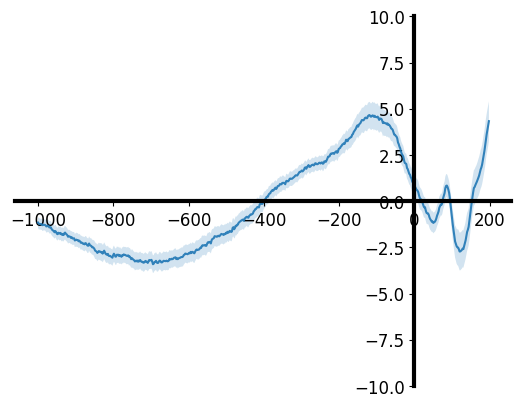

In [12]:
times = np.arange(-1000, 200, 1200/601)
plot_erp_results(data_mem_whole, times, ylim=[-10,10],labelpad=25)

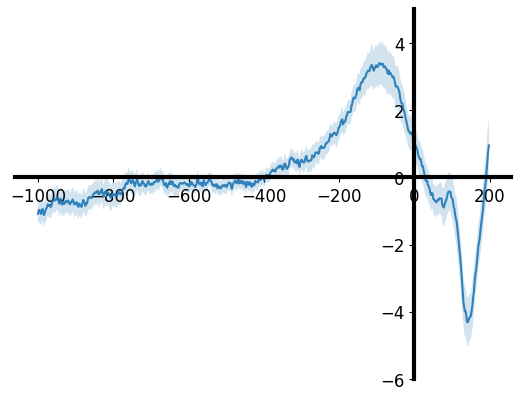

In [17]:
times = np.arange(-1000, 200, 1200/601)
plot_erp_results(data_perc_whole, times, ylim=[-6,5],labelpad=25)